# Evolução da distribuição de renda no Brasil, de 2017 a 2022

Vamos analisar os dados publicados em uma [nota técnica](https://observatorio-politica-fiscal.ibre.fgv.br/politica-economica/pesquisa-academica/concentracao-de-renda-no-topo-novas-revelacoes-pelos-dados-do)  pelo economista Sergio Gobetti. Nesse estudo preliminar, ele analisa a evolução da renda, de 2017 a 2022, de segmentos da população brasileira. Para tanto, ele utilizou dados da Receita Federal, obtidos a partir da declaração de imposto de renda (IRPF).

**Você vai aprender como:**
* [corrigir valores pela inflação](#inflacao);
* [carregar arquivos](#carregar-excel) do Excel (formatos .xls, .xlsx);
* utilizar o método de Pandas [repeat](#repeat), para repetir elementos de uma Series.

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
import sys

sys.path.append("../80_material-complementar/")
import auxiliar.geral as ag

## Funções

Aqui colocamos algumas funções que serão utilizadas nas seções seguintes.

In [2]:
class translate_dict(dict):
    """
    A dict that returns the key used if no translation was provided for it.
    """
    def __missing__(self,key):
        return key

In [3]:
def plot_boxes(matriz, cmap='summer'):
    """
    Cria um desenho de uma matriz cheia de quadradinhos cujos 
    valores são representados por uma escala de cor.
    """
    
    pl.matshow(matriz, cmap=pl.get_cmap(cmap), fignum=False)
    ax = pl.gca();

    # Minor ticks
    
    ax.set_xticks(np.arange(-.5, matriz.shape[1] + 1, 1), minor=True)
    ax.set_yticks(np.arange(-.5, matriz.shape[0] + 1, 1), minor=True)
    # Gridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=1)

    # Remove frame:
    ax.tick_params(which='both', bottom=False, left=False, top=False, labeltop=False, labelleft=False)
    for p in ['top', 'bottom', 'left', 'right']:
        ax.spines[p].set_visible(False)

In [4]:
def plot_rendas(rendas, rotulo, pos, cores='Set1'):
    """
    Cria um gráfico de barra segmentada onde a renda de um 
    segmento da população é discriminada por tipo.
    """
    
    cmap = pl.get_cmap(cores)
    
    # Loop sobre tipos de renda:
    for i in range(len(rendas)):
        # Gráfico de barras segmentadas:
        pl.bar(rotulo, rendas.iloc[i], bottom=rendas.iloc[:i].sum(), color=cmap(i), alpha=0.3)
        # Legendas:
        pl.text(pos, rendas.iloc[i] / 2 + rendas.iloc[:i].sum(), rendas.index[i], color=cmap(i), va='center', ha='center')

## Carrega os dados

Vamos carregar os dados disponibilizados pelo estudo, junto com dados auxiliares (a evolução do índice de inflação IPCA no período).

<a id="inflacao"></a>
### Índice de inflação

In [5]:
# Índice de inflação IPCA (obtidos do Portal Brasil):
ipca_df = pd.read_csv('../90_dados/economia/inflacao_ipca.csv')

Os rendimentos informados no IRPF são referentes ao ano todo. Portanto, para ajustar os valores pela inflação de 2017 a 2022, provavelmente a melhor estratégia seria calcular a média do índice (que varia mensalmente) em cada ano, e utilizar essa média para ajustar os valores. De forma mais simplificada, vamos pegar um mês de referência (igual para os dois anos).

**Correção pela inflação: ideia geral**

Os dados sobre inflação podem ser obtidos em vários sites da internet. Um deles é o [Portal Brasil](https://www.portalbrasil.net/ipca/). Também existem vários índices que medem a inflação: o IPCA, o INPC, o IGP-M, entre ourtos. Vamos utilizar o IPCA, que significa _Índice nacional de Preços ao Consumidor Amplo_. Ele mede a variação do custo de vida médio de famílias com renda mensal de 1 e 40 salários mínimos. O "número índice" do IPCA é um número que acompanha esse custo de vida. Por exemplo: se esse número dobra, significa que o custo de vida dobrou.

Para corrigir uma renda em termos do poder de compra, podemos multiplicar a renda pela razão entre índice do ano para onde queremos levar a renda e o índice do ano no qual a renda foi obtida com o seu valor nominal. Por exemplo:

$$\mathrm{Renda\: de\: dez/2017\: (em\: valores\: de\: dez/2022) = Renda\: de\: dez/2017 \times \frac{Índice\: de\: dez/2022}{Índice\: de\: dez/2017}}$$

O lado esquerdo da equação acima corresponde ao valor que seria necessário ter em dezembro de 2022 para manter o poder de compra que a renda de dezembro de 2017 tinha. A razão "$\mathrm{Índice\: de\: dez/2022\: /\: Índice\: de\: dez/2017}$" informa o quando que o custo de vida aumentou ou diminuiu.

In [6]:
# Cálculo da inflação de 2017 a 2022:
indice_final   = ipca_df.query('mes == "2022-12-01"')['indice_ipca'].iloc[0]
indice_inicial = ipca_df.query('mes == "2017-12-01"')['indice_ipca'].iloc[0]
fator_ipca = indice_final / indice_inicial
print('Inflação de dez/2017 a dez/2022 foi de {:.2f}%'.format((fator_ipca - 1) * 100))

Inflação de dez/2017 a dez/2022 foi de 31.68%


<a id="carregar-excel"></a>
### Dados de renda

Agora carregamos os dados da planilha de Excel fornecida na nota técnica. Primeiro, carregamos os dados que discriminam a renda por tipo (por exemplo, vindas do trabalho, de lucros e dividendos, etc):

**Dados do Excel:** o carregamento de dados de planilhas do Excel funciona de forma bastante similar ao do CSV 
([este tutorial que trata do básico](../06_expectativa-de-vida/10_analise_idade_med-obitos_distritos_municipio-SP.ipynb)):
1. Basta utilizar a função `pd.read_excel()` (veja abaixo).
2. Você pode informar no primeiro argumento o nome do arquivo.
3. Por padrão, ele carrega a primeira aba. Se quiser carregar outra, especifique o nome dela no parâmetro `sheet_name`.
4. Você também pode especificar a aba pela sua ordem, começando pelo 0 (e.g. `sheet_name=1` para carregar a segunda aba).
4. Assim como para arquivos CSV, é possível [pular linhas, selecionar apenas algumas colunas, etc](../06_expectativa-de-vida/20_limpeza-tratamento-dados_mortalidade.ipynb). Neste caso, usamos os parâmetros `skiprows` (para pular linhas do começo da planilha) e `skipfooter` 
(para ignorar as últimas linhas). 

In [7]:
# Carrega os dados:
renda_suja_df = pd.read_excel('dados/variacao_renda_2017-2022_FGV.xlsx', sheet_name='Sheet2', skiprows=1, skipfooter=1)

# Tratamento dos dados:
renda_df = renda_suja_df.copy()
renda_df = renda_df.dropna(how='all')
renda_df = renda_df.loc[renda_df['Centis mais ricos (IRPF)'] != 'Total']
renda_df['Ano'] = renda_df['Ano'].ffill()
renda_df = renda_df.loc[renda_df['Ano'] != 'Var (%)']
renda_df['Ano'] = renda_df['Ano'].astype(int)
renda_df['Centis mais ricos (IRPF)'] = renda_df['Centis mais ricos (IRPF)'].astype(float)

# Nomes das colunas com valores em reais:
cols_valores = list(renda_df.columns[2:])

Para complementar as informações com o número de pessoas em cada percentil, vamos carregar os dados sem discriminação por tipo de renda. Os dados originais (na aba 1) estão num formato 
muito ruim para serem lidos por um computador. Por isso, criamos, manualmente, uma versão num formato melhor, que encontra-se na aba 3.

In [8]:
# Renda e população dos centis, sem discriminação por tipo:
total_suja_df  = pd.read_excel('dados/variacao_renda_2017-2022_FGV.xlsx', sheet_name='Sheet3', skiprows=1, skipfooter=1)

## Preparação dos dados

### Deflacionando

Os dados são nominais, isto é: os valores são valores de face, em reais, da época na qual eles foram obtidos. Para comparar o poder de compra das épocas, vamos corrigir os valores de 2017 pela inflação até 2022. A ideia é que os valores resultantes correspondam a quanto que a renda era capaz de comprar em termos dos preços de 2022. 

In [9]:
# Corrigir os valores de 2017 pela inflação, até 2022:
deflac_df = renda_df.copy()
deflac_df.loc[deflac_df['Ano'] == 2017, cols_valores] = deflac_df.loc[deflac_df['Ano'] == 2017, cols_valores] * fator_ipca
# Adiciona rótulo do segmento:
deflac_df.insert(1, 'Centil', pd.Series(['Top 0,01%', 'Top 0,1%', 'Top 1%', 'Top 5%', 'Top 0,01%', 'Top 0,1%', 'Top 1%', 'Top 5%'], index=deflac_df.index))

### Completando os dados

Para a tabela de renda total (sem discriminação por tipo), vamos inferir valores que estão faltando (os referentes ao 0,01%) a partir dos presentes na mesma tabela e na outra:

In [10]:
renda_total_df = total_suja_df.copy() 

# Estima o número de contribuintes correspondentes a 0.01% da população adulta: 
pop_total_17 = renda_total_df.query('Ano == 2017').iloc[-2:]['Número de pessoas'].sum()
pop_total_22 = renda_total_df.query('Ano == 2022').iloc[-2:]['Número de pessoas'].sum()
top_pop_17   = int(pop_total_17 * 0.0001)
top_pop_22   = int(pop_total_22 * 0.0001)

# Calcula a renda anual total do Top 0.01% (em R$ milhões):
renda_top_17 = renda_df.query('Ano == 2017 and `Centis mais ricos (IRPF)` < 0.001')['Total'].iloc[0] * 12 * top_pop_17 / 1e6
renda_top_22 = renda_df.query('Ano == 2022 and `Centis mais ricos (IRPF)` < 0.001')['Total'].iloc[0] * 12 * top_pop_22 / 1e6

# Cria tabela para o 0.01%:
total_inferida_df = pd.DataFrame()
total_inferida_df['Centil'] = pd.Series(['Top 0,01%', 'Top 0,01%'])
total_inferida_df['Ano']    = pd.Series([2017, 2022])
total_inferida_df['Renda (R$ milhões)'] = pd.Series([renda_top_17, renda_top_22])
total_inferida_df['Número de pessoas']  = pd.Series([top_pop_17, top_pop_22])

# Agrega valores do 0,01% à tabela:
renda_total_df = pd.concat([total_inferida_df, renda_total_df], ignore_index=True)

# Calcula a renda mensal média (nominal):
renda_total_df['Renda média mensal'] = renda_total_df['Renda (R$ milhões)'] * 1e6 / renda_total_df['Número de pessoas'] / 12

In [11]:
renda_total_df

,Centil,Ano,Renda (R$ milhões),Número de pessoas,Renda média mensal
0,"Top 0,01%",2017,1.989421e+05,1.498000e+04,1.106710e+06
1,"Top 0,01%",2022,4.018533e+05,1.543400e+04,2.169741e+06
2,"Top 0,1%",2017,4.310696e+05,1.522880e+05,2.358851e+05
3,"Top 0,1%",2022,8.137349e+05,1.536660e+05,4.412898e+05
4,Top 1%,2017,9.612243e+05,1.522882e+06,5.259897e+04
5,Top 1%,2022,1.618599e+06,1.536670e+06,8.777634e+04
6,Top 5%,2017,1.715713e+06,7.309833e+06,1.955941e+04
7,Top 5%,2022,2.719899e+06,7.683352e+06,2.949992e+04
8,Demais 95%,2017,2.988518e+06,1.424933e+08,1.747754e+03
9,Demais 95%,2022,4.103959e+06,1.466628e+08,2.331856e+03


Vamos agora calcular a renda total de cada segmento da população e o tamanho dos segmentos, em número de pessoas:

In [12]:
renda_segmento_df = renda_total_df.copy()

# Nomeia os segmentos:
renda_segmento_df.rename({'Centil':'Segmento'}, axis=1, inplace=True)
traducao_segmentos = translate_dict({'Top 0,1%': '0,01% a 0,1%', 'Top 1%': '0,1% a 1%', 'Top 5%': '1% a 5%'})
renda_segmento_df['Segmento'] = renda_segmento_df['Segmento'].map(traducao_segmentos)

col_valores = ['Renda (R$ milhões)', 'Número de pessoas']
# Seleciona linhas que precisam ser alteradas:
sel17 = (renda_segmento_df['Ano'] == 2017) & ~renda_segmento_df['Segmento'].isin(['Top 0,01%', 'Demais 95%'])
sel22 = (renda_segmento_df['Ano'] == 2022) & ~renda_segmento_df['Segmento'].isin(['Top 0,01%', 'Demais 95%'])
# Coloca valor dos segmentos:
renda_segmento_df.loc[sel17, col_valores] = renda_segmento_df.query('Ano == 2017')[col_valores].diff().iloc[1:-1]
renda_segmento_df.loc[sel22, col_valores] = renda_segmento_df.query('Ano == 2022')[col_valores].diff().iloc[1:-1]

# Calcula a renda mensal média (nominal):
renda_segmento_df['Renda média mensal'] = renda_segmento_df['Renda (R$ milhões)'] * 1e6 / renda_segmento_df['Número de pessoas'] / 12

Vamos corrigir os valores de 2017 da tabela pela inflação:

In [13]:
# Correção dos valores não-discriminados pela inflação:
deflac_total_df = renda_segmento_df.copy()
tot_cols_valores = ['Renda (R$ milhões)', 'Renda média mensal']
deflac_total_df.loc[deflac_total_df['Ano'] == 2017, tot_cols_valores] = deflac_total_df.loc[deflac_total_df['Ano'] == 2017, tot_cols_valores] * fator_ipca

### Segmentando a renda discriminada por tipo

Vamos agora tratar os dados que discriminam o tipo de renda:

In [14]:
# Junta quantidade de pessoas em cada Centil:
deflac_pessoas_df = deflac_df.join(renda_total_df.set_index(['Ano', 'Centil'])['Número de pessoas'], on=['Ano', 'Centil'], how='left')

# Calcula a renda mensal total do centil:
deflac_pessoas_df.loc[:, cols_valores] = deflac_pessoas_df.loc[:, cols_valores].multiply(deflac_pessoas_df['Número de pessoas'], axis=0)

# Calcula os valores dos segmentos:
sel17 = (deflac_pessoas_df['Ano'] == 2017) & (deflac_pessoas_df['Centil'] != 'Top 0,01%')
deflac_pessoas_df.loc[sel17, cols_valores + ['Número de pessoas']] = deflac_pessoas_df.loc[deflac_pessoas_df['Ano'] == 2017, cols_valores + ['Número de pessoas']].diff().iloc[1:]
sel22 = (deflac_pessoas_df['Ano'] == 2022) & (deflac_pessoas_df['Centil'] != 'Top 0,01%')
deflac_pessoas_df.loc[sel22, cols_valores + ['Número de pessoas']] = deflac_pessoas_df.loc[deflac_pessoas_df['Ano'] == 2022, cols_valores + ['Número de pessoas']].diff().iloc[1:]

# Nomeia os segmentos:
deflac_pessoas_df.rename({'Centil':'Segmento'}, axis=1, inplace=True)
deflac_pessoas_df['Segmento'] = deflac_pessoas_df['Segmento'].map(traducao_segmentos)

In [15]:
# Calcula a renda média para cada segmento:
deflac_segmento_df = deflac_pessoas_df.copy()
deflac_segmento_df.loc[:, cols_valores] = deflac_segmento_df.loc[:, cols_valores].divide(deflac_segmento_df['Número de pessoas'], axis=0)

In [16]:
deflac_segmento_df

,Ano,Segmento,Centis mais ricos (IRPF),Renda do trabalho,Lucros e dividendos (+JCP),Atividade rural,Outras rendas do capital,Demais,Total,Número de pessoas
1,2017,"Top 0,01%",0.000102,126756.684893,6.372973e+05,49039.380903,460849.304224,183386.943371,1.457330e+06,14980.0
2,2017,"0,01% a 0,1%",0.001017,38222.001642,7.665330e+04,9554.861316,37609.117635,23473.413162,1.855127e+05,137308.0
3,2017,"0,1% a 1%",0.010166,23347.123440,8.966763e+03,1289.811994,4851.843016,3990.447370,4.244599e+04,1370594.0
4,2017,1% a 5%,0.048796,10909.707759,1.241569e+03,407.985824,927.202034,820.436832,1.430690e+04,5786951.0
6,2022,"Top 0,01%",0.000100,118314.987743,1.060828e+06,129669.999847,572291.103987,288636.965436,2.169741e+06,15434.0
7,2022,"0,01% a 0,1%",0.000996,31902.573871,1.190757e+05,22058.134234,41207.346915,34059.526848,2.483033e+05,138232.0
8,2022,"0,1% a 1%",0.009956,19887.107947,1.472002e+04,2252.053700,5699.722485,5938.446585,4.849735e+04,1383004.0
9,2022,1% a 5%,0.049780,10225.098195,2.054899e+03,437.571035,1097.102613,1116.141865,1.493081e+04,6146682.0


## Análises

<a id="repeat"></a>
### População adulta em 2017

Vamos criar uma representação gráfica da quantidade de pessoas que compõe casa segmento da população. Como o menor segmento contém 0,01% (ou 1/10000) da população adulta, 
vamos considerar 10.000 blocos de pessoas, de maneira que o 0,01% será representado por apenas 1 bloco. Dado que a população adulta em 2017 era de, aproximadamente, 
150 milhões de pessoas, cada bloco representa 15 mil pessoas.

Para isso, vamos utilizar o método `repeat()`:
1. Primeiro, definimos uma Series (que chamamos `blocos_df['val']`) com valores da escala de cor a serem repetidos (cada um será um bloco).
2. Depois definimos outra Series (que chamamos `blocos_df['n_blocos']`) com o número de repetições que queremos de cada um desses valores (i.e. o número de blocos).
3. Em seguida, chamamos o método `repeat()` da série de valores, passando como argumento o número de repetições de cada um.
4. O resultado é uma nova Series com os valores repetidos o número especificados de vezes.

In [51]:
# Número de blocos (cada um representando, aproximadamente, 15 mil pessoas) em cada segmento:
escala_cor = [0.0, 0.3, 0.5, 0.7, 0.9] # summer
escala_cor = [0.0, 0.4, 0.5, 0.7, 0.8] # magma
blocos_df = pd.DataFrame({'id':[0, 1, 2, 3, 4], 'val':escala_cor, 'n_blocos': [1, 9, 90, 400, 9500]})

# Criamos uma matriz onde cada bloco se repete o número de vezes necessário para representar o segmento da população: 
matriz_blocos = blocos_df['val'].repeat(blocos_df['n_blocos']).values.reshape((50, 200))

Vamos fazer o mesmo, mas para a renda. Isto é: vamos distribuir a renda total nacional de 2017 em 10.000 blocos e ver como que cada bloco é apropriado por cada segmento da população,
utilizando como representação desses grupos as mesmas cores utilizadas acima.

In [48]:
# Seleciona dados de 2017:
bloco_renda_17_df = deflac_total_df.query('Ano == 2017').set_index('Segmento').copy()

# Contabiliza número de blocos de renda que cada segmento tem:
bloco_renda_min = bloco_renda_17_df['Renda (R$ milhões)'].sum() / 10000
bloco_renda_17_df['Unidades de renda'] = (bloco_renda_17_df['Renda (R$ milhões)'] / bloco_renda_min).round().astype(int)
bloco_renda_17_df['val'] = pd.Series(escala_cor, index=bloco_renda_17_df.index)

# Cria a representação matricial:
matriz_renda = bloco_renda_17_df['val'].repeat(bloco_renda_17_df['Unidades de renda']).values.reshape((50, 200))

Vamos criar o gráfico:

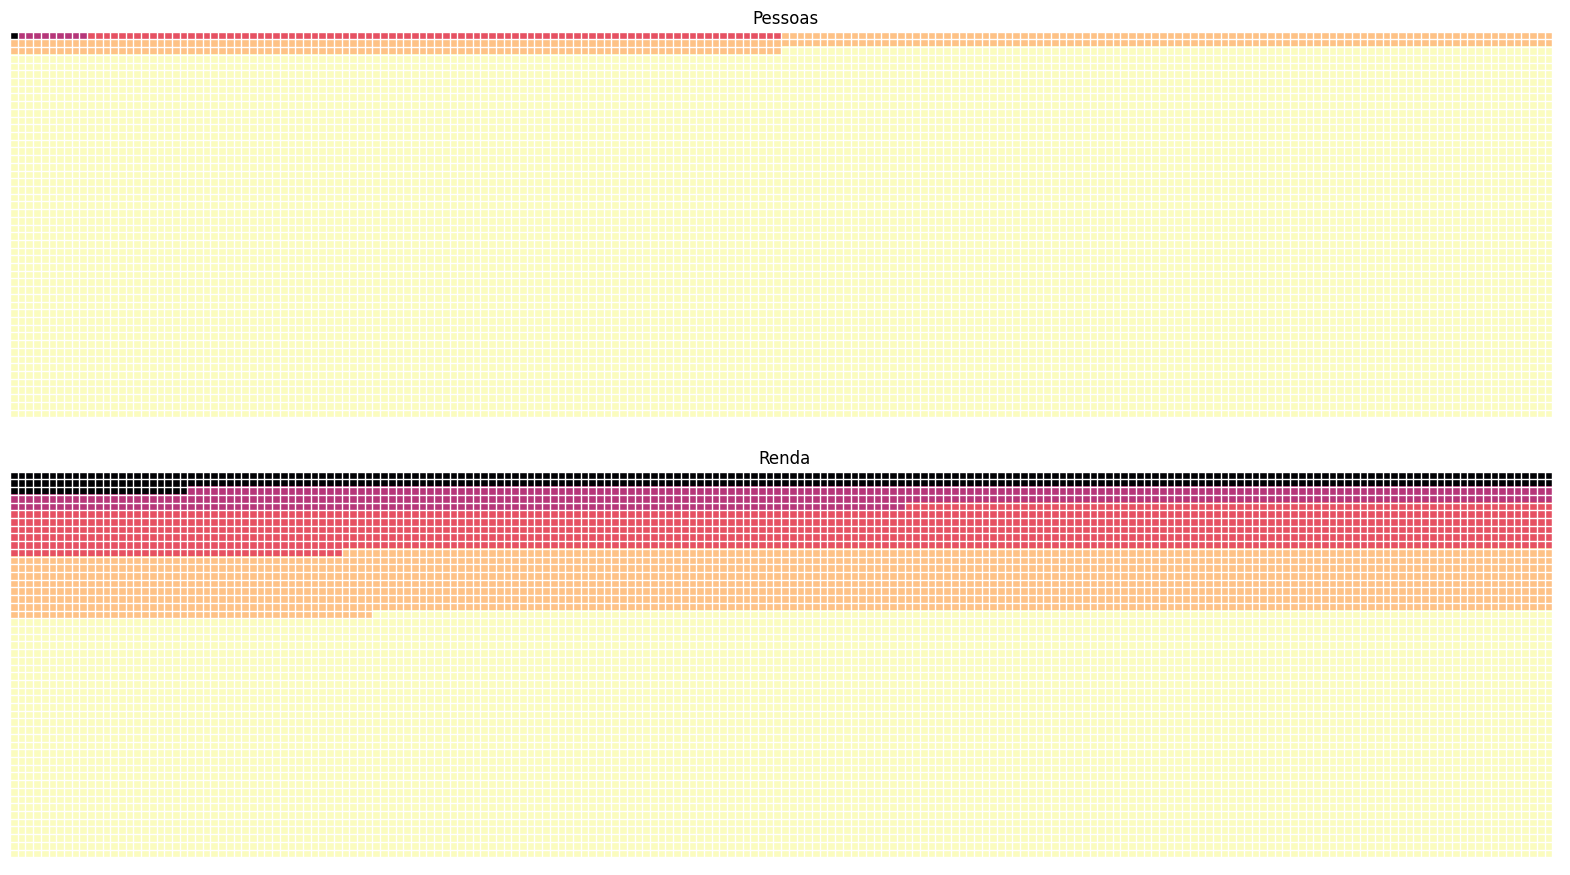

In [49]:
fig = pl.figure(figsize=(20,20))

pl.subplot(2,1,1)
pl.title('Pessoas')
plot_boxes(matriz_blocos, 'magma')

pl.subplot(2,1,2)
pl.title('Renda')
plot_boxes(matriz_renda, 'magma')
pl.subplots_adjust(hspace=-0.6)

### Desigualdade inicial, em 2017

Vamos visualizar em um gráfico a renda mensal média de cada segmento da população adulta. Vamos usar os valores de 2017, mas corrigidos para os preços de 2022 (isto é, corrigidos pela inflação).

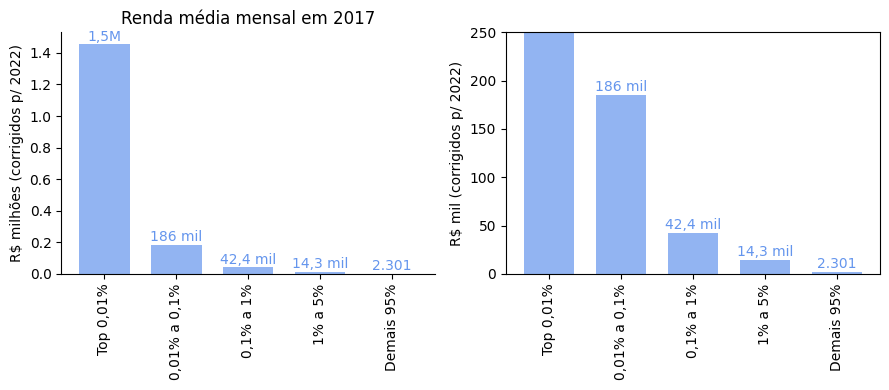

In [20]:
graf = deflac_total_df.query('Ano == 2017').set_index('Segmento')['Renda média mensal']

pl.figure(figsize=(9,4))

# Gráfico geral:
pl.subplot(1,2,1)
# Gráfico:
pl.title('Renda média mensal em 2017')
(graf / 1e6).plot(kind='bar', color='cornflowerblue', alpha=0.7, width=0.7)
# Valores das barras:
for i in range(len(graf)):
    pl.text(i, graf.iloc[i] / 1e6 + 0.02, ag.number_BM_notation(graf.iloc[i]), ha='center', color='cornflowerblue')
# Formatação:
pl.ylabel('R$ milhões (corrigidos p/ 2022)')
pl.xlabel(None)
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Zoom:
pl.subplot(1,2,2)
(graf / 1e3).plot(kind='bar', color='cornflowerblue', alpha=0.7, width=0.7)
# Valores das barras:
for i in range(1, len(graf)):
    pl.text(i, graf.iloc[i] / 1e3 + 4, ag.number_BM_notation(graf.iloc[i]), ha='center', color='cornflowerblue')
# Formatação
pl.ylim([0, 250])
pl.ylabel('R$ mil (corrigidos p/ 2022)')
pl.xlabel(None)

pl.tight_layout()
#pl.savefig('graficos/renda-media-mensal_2017-IPCA.png', dpi=250)
pl.show()

### Variação da renda média mensal

Agora vamos ver quanto que a renda de cada segmento cresceu no período de 2017 a 2022, descontada a inflação.

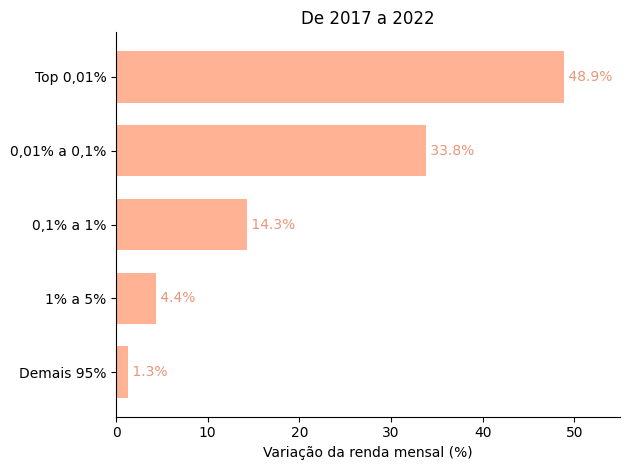

In [21]:
# Calcula a variação percentual da renda de cada segmento:
renda_17  = deflac_total_df.query('Ano == 2017').set_index('Segmento')['Renda média mensal']
renda_22  = deflac_total_df.query('Ano == 2022').set_index('Segmento')['Renda média mensal']
var_renda = (renda_22 / renda_17 - 1) * 100

# Faz o gráfico:
var_renda.iloc[::-1].plot(kind='barh', zorder=2, color='lightsalmon', alpha=0.8, width=0.7)
# Adiciona os valores no final das barras:
for i in range(len(var_renda)):
    v = var_renda.iloc[i]
    pl.text(v, len(var_renda) - i - 1, ' {:.1f}%'.format(v), va='center', color='darksalmon')
# Formatação:
pl.title('De 2017 a 2022')
pl.xlabel('Variação da renda mensal (%)')
pl.ylabel(None)
pl.xlim([0, 55])
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.tight_layout()
#pl.savefig('graficos/aumento-real-percentual-renda_2017-2022.png', dpi=250)
pl.show()

### Variação da partilha da renda nacional 

Em relação a somatória da renda de todas as pessoas, a qual parcela corresponde a renda de cada segmento? Vamos ver isso para 2017 e para 2022.

In [22]:
deflac_total_df.set_index(['Ano', 'Segmento'])['Número de pessoas'].sort_index() / 1000

Ano   Segmento    
2017  0,01% a 0,1%       137.30800
      0,1% a 1%         1370.59400
      1% a 5%           5786.95100
      Demais 95%      142493.30395
      Top 0,01%           14.98000
2022  0,01% a 0,1%       138.23200
      0,1% a 1%         1383.00400
      1% a 5%           6146.68200
      Demais 95%      146662.84600
      Top 0,01%           15.43400
Name: Número de pessoas, dtype: float64

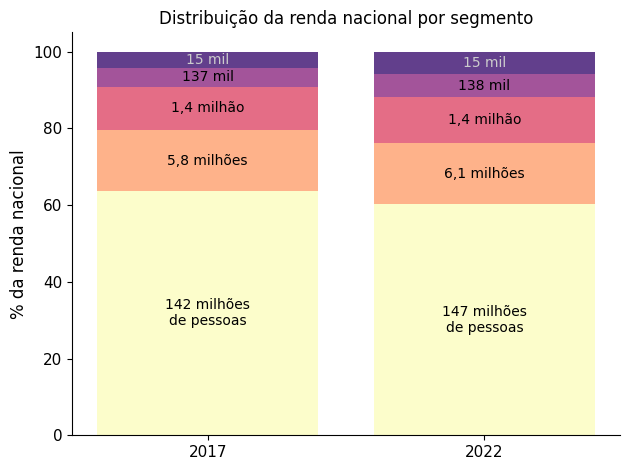

In [45]:
# Textos (rótulos) para o gráfico:
n_pessoas_17 = ['142 milhões\nde pessoas', '5,8 milhões', '1,4 milhão', '137 mil', '15 mil']
n_pessoas_22 = ['147 milhões\nde pessoas', '6,1 milhões', '1,4 milhão', '138 mil', '15 mil']
n_pessoas = {'2017': n_pessoas_17, '2022': n_pessoas_22}
# Escala de cor do gráfico:
cmap = pl.get_cmap('magma_r')

# Loop sobre os anos:
for a in ['2017', '2022']:
    # Calcula a fração da renda total capturada por cada segmento:
    ano_df = deflac_total_df.query('Ano == {}'.format(a)).set_index('Segmento').iloc[::-1]
    fracao_renda = ano_df['Renda (R$ milhões)'] / ano_df['Renda (R$ milhões)'].sum() * 100
    n_segmentos = len(fracao_renda)
    # Coloca os segmentos no gráfico:
    for i in range(n_segmentos):
        pl.bar(a, fracao_renda.iloc[i], bottom=fracao_renda.iloc[:i].sum(), color=cmap(i / n_segmentos), alpha=0.8)
        if i == n_segmentos - 1:
            c = '0.8'
        else:
            c = 'k'
        pl.text(a, fracao_renda.iloc[i] / 2 + fracao_renda.iloc[:i].sum(), n_pessoas[a][i], va='center', ha='center', color=c, fontsize=10)

# Formatação:
pl.title('Distribuição da renda nacional por segmento')
ax = pl.gca()
pl.tick_params(labelsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.ylabel('% da renda nacional', fontsize=12)
pl.tight_layout()
pl.savefig('graficos/distribuicao-renda-nacional_2017-2022.png', dpi=300)
pl.show()

### Variação da renda por tipo e segmento

Vamos ver novamente como que a renda de cada segmento variou de 2017 a 2022, mas agora separando por tipo de renda (renda do trabalho, lucros e dividendos, etc).

In [24]:
import auxiliar.graficos as ap

In [25]:
# Variação percentual de cada tipo de renda, para cada segmento:
var_por_tipo_df = (deflac_segmento_df.query('Ano == 2022').set_index('Segmento')[cols_valores] / deflac_segmento_df.query('Ano == 2017').set_index('Segmento')[cols_valores] - 1) * 100

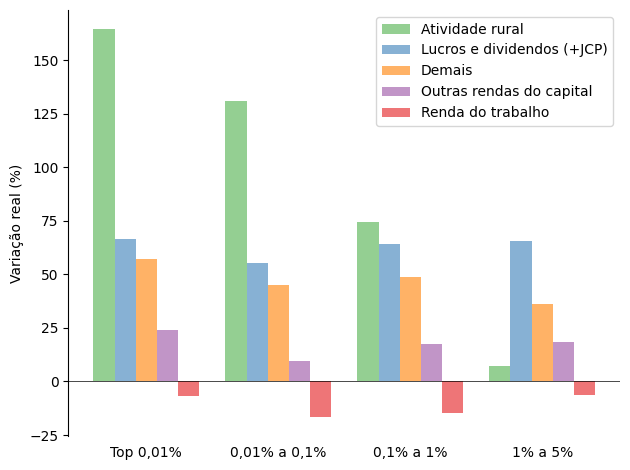

In [26]:
# Tipos de renda e respectivas cores:
tipos_renda = ['Atividade rural', 'Lucros e dividendos (+JCP)', 'Demais', 'Outras rendas do capital', 'Renda do trabalho']
cmap = pl.get_cmap('Set1')
tipos_cores = [cmap(i) for i in [2, 1, 4, 3, 0]]
# Cria o gráfico:
ap.multiple_bars_plot(var_por_tipo_df[tipos_renda], colors=tipos_cores, alpha=0.6)
# Formatação:
pl.ylabel('Variação real (%)')
pl.axhline(0, color='k', linewidth=0.5)
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
pl.tick_params(bottom=False)
pl.legend()
pl.tight_layout()
#pl.savefig('graficos/aumento-real-percentual-renda-por-tipo_2017-2022.png', dpi=250)
pl.show()

### Variação na composição da renda

Vamos acompanhar a evolução da renda de 2017 a 2022 de dois segmentos sociais. Vamos descrever a renda em cada ano em termos dos valores obtidos em cada tipo.

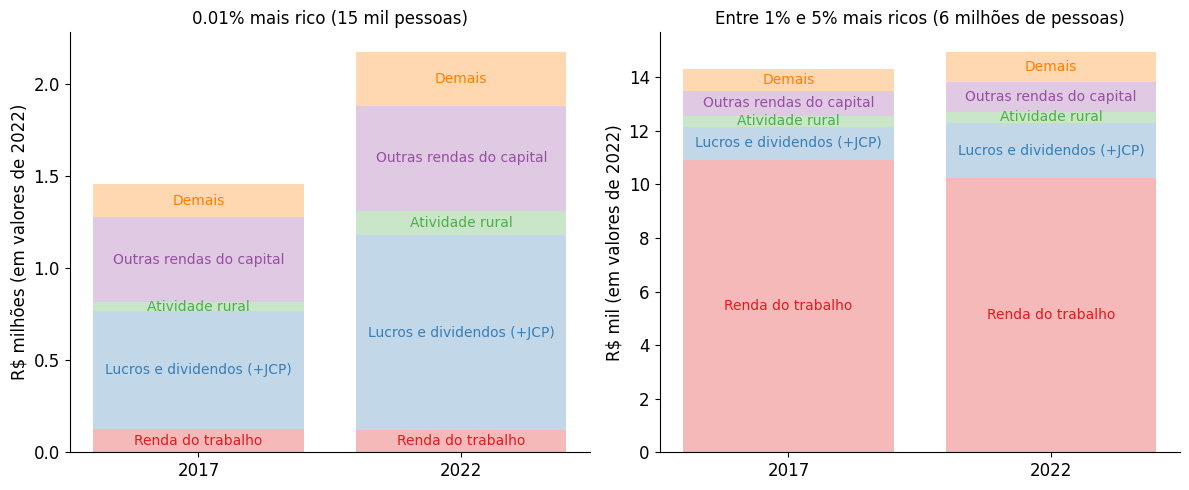

In [27]:
pl.figure(figsize=(12,5))

pl.subplot(1,2,1)
#pl.title('Renda média mensal do 0.01% mais rico (15 mil pessoas)')
pl.title('0.01% mais rico (15 mil pessoas)')
plot_rendas(deflac_segmento_df.iloc[0][cols_valores[:-1]] / 1e6, '2017', 0)
plot_rendas(deflac_segmento_df.iloc[4][cols_valores[:-1]] / 1e6, '2022', 1)
pl.ylabel('R$ milhões (em valores de 2022)', fontsize=12)
ax = pl.gca()
pl.tick_params(labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pl.subplot(1,2,2)
#pl.title('Renda média mensal dos entre 1% e 5% mais ricos (6 milhões de pessoas)')
pl.title('Entre 1% e 5% mais ricos (6 milhões de pessoas)')
plot_rendas(deflac_segmento_df.iloc[3][cols_valores[:-1]] / 1e3, '2017', 0)
plot_rendas(deflac_segmento_df.iloc[7][cols_valores[:-1]] / 1e3, '2022', 1)
pl.ylabel('R$ mil (em valores de 2022)', fontsize=12)
ax = pl.gca()
pl.tick_params(labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.tight_layout()
#pl.savefig('graficos/renda-por-tipo-segmento-ano.png', dpi=300)
pl.show()

### E se toda a variação de renda fosse direcionada ao 95% menos rico da população?

In [28]:
# Seleciona dados dos anos:
total_17_df = deflac_total_df.query('Ano == 2017').set_index('Segmento')
total_22_df = deflac_total_df.query('Ano == 2022').set_index('Segmento')

In [29]:
# Mantendo a renda per capita de cada segmento constante, quanta renda sobra:
acrescimo_milhoes = total_22_df['Renda (R$ milhões)'] - total_17_df['Renda (R$ milhões)'] * total_22_df['Número de pessoas'] / total_17_df['Número de pessoas']

In [30]:
# Distribuindo esse valor entre 95% da população:
possivel_aumento = acrescimo_milhoes.drop('Demais 95%').sum() / total_22_df.loc['Demais 95%', 'Número de pessoas'] * 1e6 / 12

In [31]:
# Resultado:
v17 = total_17_df.loc['Demais 95%', 'Renda média mensal']
v22 = total_22_df.loc['Demais 95%', 'Renda média mensal']
modelo_frase = 'A renda de 95% da população poderia ter tido um aumento real de {:.2f}% em relação a 2017, ao invés de {:.2f}%.'
print(modelo_frase.format((v22 + possivel_aumento) / v17 * 100 - 100, v22 / v17 * 100 - 100))

A renda de 95% da população poderia ter tido um aumento real de 10.77% em relação a 2017, ao invés de 1.32%.


<center>
    <img src="https://nucleodetecnologia.com.br/assets/img/novo-logo-tecnologia.svg?bl=tutorial-dist-renda-10" width="150">
</center>